# CURRENT Cross-View
takes in already matched, rotated, and cropped images that come from Noah's code

taken from 3b. orientated_slices in OneDrive

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image, ImageDraw
import random

# Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        backbone = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])  # Remove fully connected layers

    def forward(self, x):
        return self.feature_extractor(x)  # Output feature map

# Cross-View Transformer
class CrossViewTransformer(nn.Module):
    def __init__(self, feature_dim, num_heads, num_layers):
        super(CrossViewTransformer, self).__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=feature_dim, nhead=num_heads, dim_feedforward=1024, activation='relu')
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(feature_dim)

    def forward(self, query, key, value):
        for layer in self.layers:
            query = layer(query + key + value)
        return self.norm(query)

# Detect Foreground Tissue Region
def calculate_foreground_region(image_path):
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    np_image = np.array(image)
    binary_mask = np_image > 10  # Non-black pixels as tissue
    coords = np.argwhere(binary_mask)
    if coords.size == 0:
        raise ValueError(f"No tissue detected in image: {image_path}")
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return y_min, y_max, x_min, x_max

def extract_patch(image, region, patch_size=(256, 256)):
    y_min, y_max, x_min, x_max = region

    # Calculate the bounding box dimensions
    box_height = y_max - y_min
    box_width = x_max - x_min

    # Define the center of the bounding box
    y_center = (y_min + y_max) // 2
    x_center = (x_min + x_max) // 2

    # Generate random offsets for the patch center
    max_y_offset = min(box_height // 4, y_center - y_min, y_max - y_center)
    max_x_offset = min(box_width // 4, x_center - x_min, x_max - x_center)

    y_offset = random.randint(-max_y_offset, max_y_offset)
    x_offset = random.randint(-max_x_offset, max_x_offset)

    # Apply the random offset to the patch center
    y_center += y_offset
    x_center += x_offset

    # Ensure the patch fits within the image boundaries
    x_start = max(0, x_center - patch_size[0] // 2)
    y_start = max(0, y_center - patch_size[1] // 2)
    x_end = min(image.width, x_start + patch_size[0])
    y_end = min(image.height, y_start + patch_size[1])

    # Crop the patch from the image
    patch = image.crop((x_start, y_start, x_end, y_end))
    return patch, (x_start, y_start, x_end, y_end)

# Draw Bounding Box on the Original Image
def draw_bounding_box(image, box_coords, color="blue", thickness=3):
    draw = ImageDraw.Draw(image)
    x_start, y_start, x_end, y_end = box_coords
    for i in range(thickness):
        draw.rectangle([x_start - i, y_start - i, x_end + i, y_end + i], outline=color)

# Save Patch as Image
def save_patch_as_image(patch, output_folder, stain_name):
    os.makedirs(output_folder, exist_ok=True)
    patch.save(os.path.join(output_folder, f"{stain_name}_aligned_patch.png"))

# Preprocess Image
def preprocess_image(image_path, input_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0), image

# Main Processing Pipeline- adjust patch_size parameter to increase/decrease size of patch
def process_rotated_images(image_paths, patch_size=(128, 128), output_folder="aligned_patches"):
    # Load and preprocess images
    tensors, images, regions = [], [], []
    for path in image_paths:
        tensor, image = preprocess_image(path)
        region = calculate_foreground_region(path)
        tensors.append(tensor)
        images.append(image)
        regions.append(region)

    feature_extractor = FeatureExtractor()
    feature_dim = 2048
    cross_view_transformer = CrossViewTransformer(feature_dim=feature_dim, num_heads=8, num_layers=4)

    # Extract features for all images
    features = [feature_extractor(tensor) for tensor in tensors]
    b, c, h, w = features[0].shape
    flattened_features = [f.flatten(2).permute(0, 2, 1) for f in features]

    # Align features across views
    aligned_features = [
        cross_view_transformer(flattened_features[0], flattened_features[1], flattened_features[2]),
        cross_view_transformer(flattened_features[1], flattened_features[0], flattened_features[2]),
        cross_view_transformer(flattened_features[2], flattened_features[0], flattened_features[1]),
    ]

    # Reshape aligned features
    aligned_images = [
        af.permute(0, 2, 1).reshape(b, c, h, w) for af in aligned_features
    ]

    # Extract patches
    patches, coords = [], []
    for image, region in zip(images, regions):
        patch, coord = extract_patch(image, region, patch_size)
        patches.append(patch)
        coords.append(coord)

    # Draw bounding boxes and save results
    annotated_output_folder = os.path.join(output_folder, "annotated")
    os.makedirs(annotated_output_folder, exist_ok=True)
    for img, coord, name in zip(images, coords, ["H&E", "Melan", "Sox10"]):
        draw_bounding_box(img, coord, color="red")
        img.save(os.path.join(annotated_output_folder, f"{name}_with_bbox.png"))

    for patch, name in zip(patches, ["H&E", "Melan", "Sox10"]):
        save_patch_as_image(patch, output_folder, name)

    return patches

# Run the Pipeline
if __name__ == "__main__":
    image_paths = [
        'h2114153  h&e.tif',
        'h2114153  melan.tif',
        'h2114153 sox10.tif',
    ]

    patches = process_rotated_images(image_paths)
    print("Aligned patches saved successfully.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]


Aligned patches saved successfully.


# H&E- Prashant
takes in already matched extracted h&e slice. no preprocessing

Output directory 'extracted' created.
Output visualization directory 'extracted/visualization' created.
Processing image: h2114153  h&e_ROI_5.tif
extracted/h2114153  h&e_ROI_5.tif Epithelia.png saved
extracted/h2114153  h&e_ROI_5.tif Stroma.png saved
extracted/visualization/h2114153  h&e_ROI_5.tif.png saved
Segmentation complete for single image.


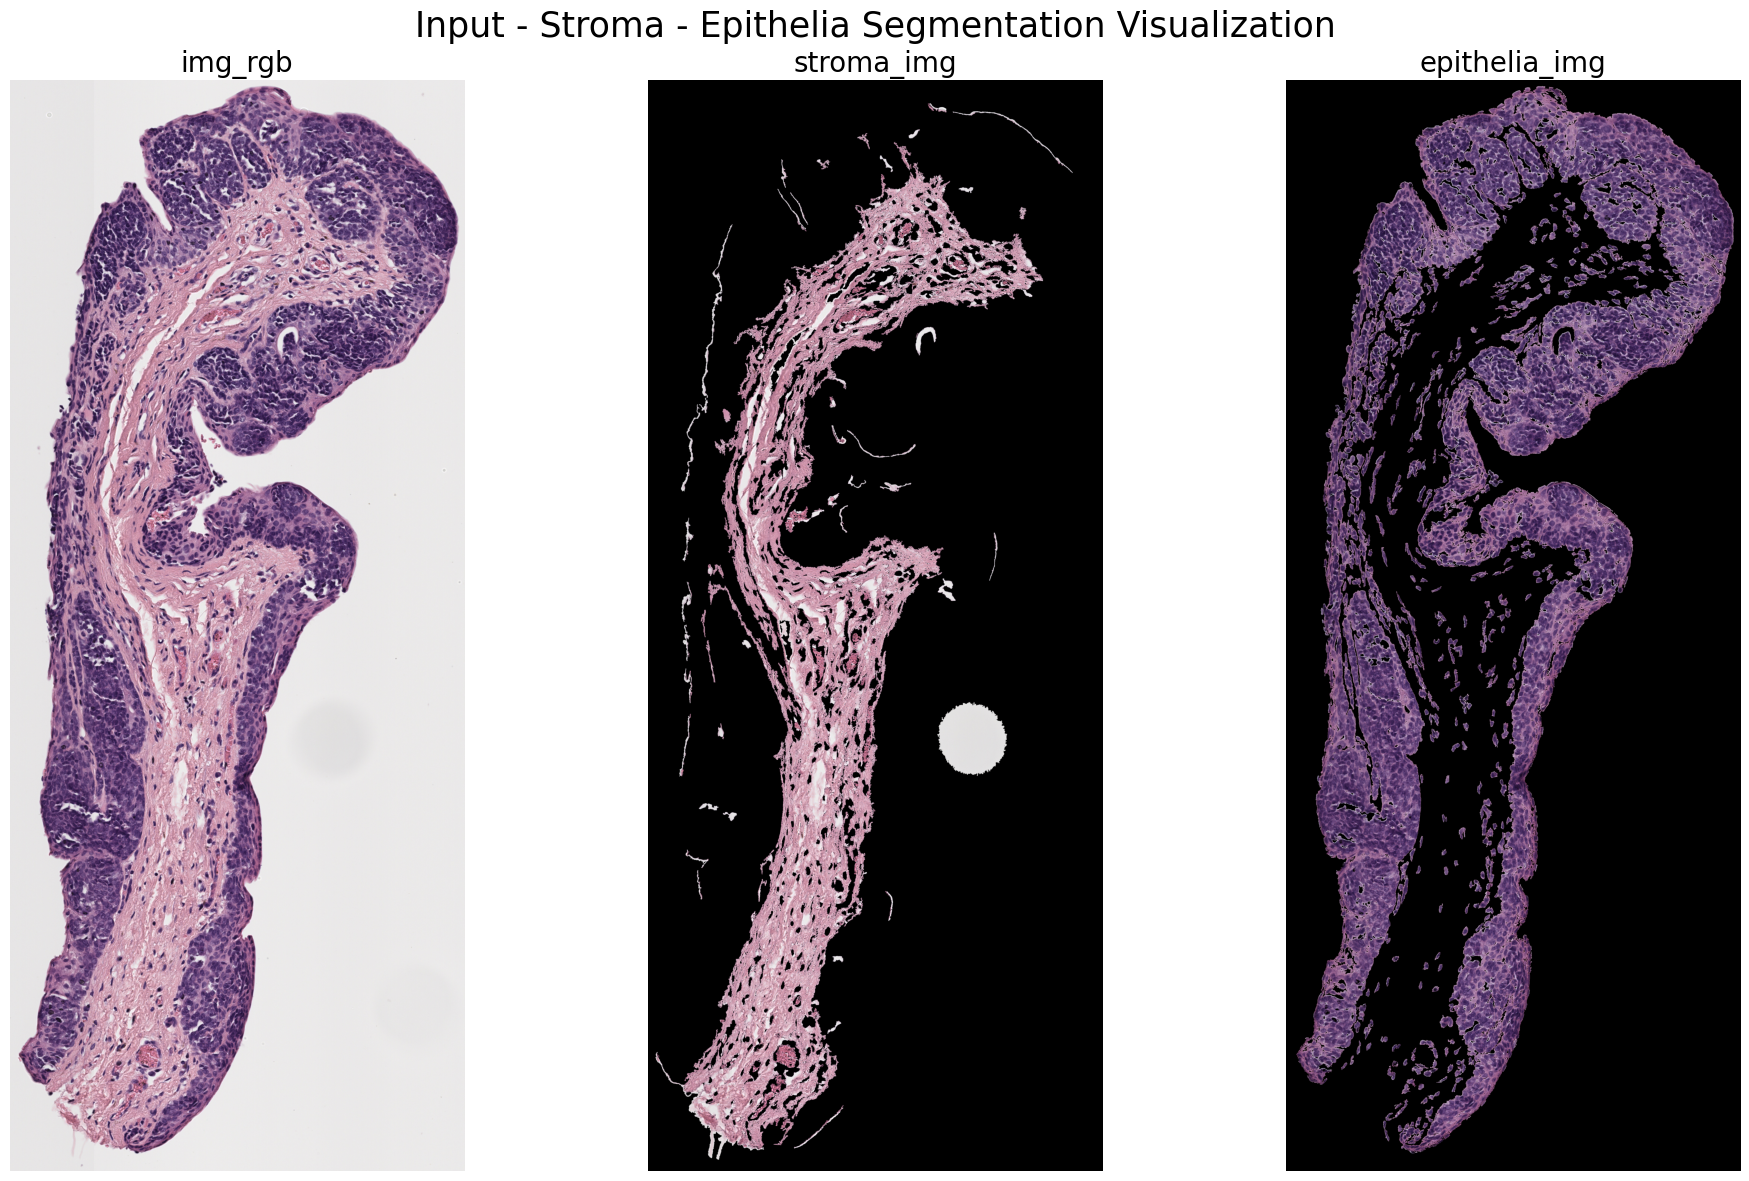

In [2]:
##########################################
##       SEGMENTATION ALGORITHM         ##
##########################################

show_images = 0                                 # to display images in real-time
save_intermediate_images = 0                    # save R-G-B and Y-Cb-Cr Channels
output_dir = "extracted"                        # epithelia and stroma will be saved here
overwrite_output = 0                            # to overwrite previous output
image_name = 'h2114153  h&e_ROI_5.tif'         # specific image to run with 'run_over_all_images = 0'
save_epithelia_and_stroma = 1                   # to save epithelia and stroma output

# Visualization settings
output_visualization_dir = "extracted/visualization"  # output for visual comparison
save_bins_representation = 0                    # to save Lumma and Red Chroma Bins for visualization

##########################################

import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import morphology
import gc

# Plot the image
def imshow(img, title):
    global show_images
    if show_images == 0:
        return

    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    plt.title(title)
    plt.show(block=True)
    plt.close('all')

# Check and create necessary directories
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
    print(f"Output directory '{output_dir}' created.")

if not os.path.isdir(output_visualization_dir):
    os.mkdir(output_visualization_dir)
    print(f"Output visualization directory '{output_visualization_dir}' created.")

# Process single image
input_filepath = image_name  # Set input filepath directly for a single image
if not os.path.isfile(input_filepath):
    print(f"File '{input_filepath}' does not exist! Exiting...")
    exit()

# Load Image
print(f"Processing image: {input_filepath}")
img_rgb = cv2.imread(input_filepath)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
imshow(img_rgb, 'img_rgb')

if save_bins_representation or show_images:
    fig = plt.figure(num=1, clear=True, figsize=(20, 12))
    ax_arr = fig.subplots(1, 4, sharex=True, sharey=True)
    fig.suptitle('RGB - R - G - B', fontsize=25)
    ax1, ax2, ax3, ax4 = ax_arr.ravel()
    ax1.imshow(img_rgb)
    ax1.set_title('RGB888', fontsize=20)
    ax1.set_axis_off()
    ax2.imshow(img_rgb[:, :, 0])
    ax2.set_title('Red Channel', fontsize=20)
    ax2.set_axis_off()
    ax3.imshow(img_rgb[:, :, 1])
    ax3.set_title('Green Channel', fontsize=20)
    ax3.set_axis_off()
    ax4.imshow(img_rgb[:, :, 2])
    ax4.set_title('Blue Channel', fontsize=20)
    ax4.set_axis_off()
    plt.tight_layout()
    if save_bins_representation:
        filename = os.path.join(output_visualization_dir, image_name + " RGB Channels.png")
        plt.savefig(filename)
        print(f"{filename} saved")

    if show_images:
        plt.show()

# Convert to YCrCb color space
img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)

# Define binning in lumma image
lumma_bins_n = 20
divisor = (np.floor(255 / lumma_bins_n)).astype(np.uint8)
lumma_binned = (np.floor(img_ycrcb[:, :, 0] / divisor)).astype(np.uint8)

if save_bins_representation:
    fig = plt.figure(num=1, clear=True, figsize=(20, 12))
    ax_arr = fig.subplots(2, int(lumma_bins_n / 2) + 1, sharex=True, sharey=True)
    fig.suptitle(image_name + " Lumma " + str(lumma_bins_n) + " Bins Representation", fontsize=25)
    row, col = 0, 0
    for bin_i in range(0, lumma_bins_n + 2):
        ax_arr[row, col].set_title("bin " + str(bin_i), fontsize=20)
        ax_arr[row, col].set_axis_off()
        ax_arr[row, col].imshow(lumma_binned == bin_i)
        col += 1
        if col == int(lumma_bins_n / 2) + 1:
            row += 1
            col = 0
    plt.tight_layout()
    filename = os.path.join(output_visualization_dir, image_name + " Lumma " + str(lumma_bins_n) + " Bins Representation.png")
    plt.savefig(filename)
    print(filename + " saved")
    if show_images:
        plt.show()

# Find background based on most populated lumma bin
most_pixels_bin = np.argmax(np.bincount(lumma_binned.ravel()))
background = lumma_binned == most_pixels_bin
background = morphology.remove_small_objects(background, 5000)
background = morphology.remove_small_holes(background, 10000)

if save_intermediate_images:
    filename = os.path.join(output_dir, image_name + " Lumma Background Mask.png")
    cv2.imwrite(filename, background.astype(np.uint8) * 255, [cv2.IMWRITE_PNG_COMPRESSION, 0])
    print(f"{filename} saved")

# Red Chroma segmentation for stroma and epithelia
Cr_bins_n = 50
Cr_binned = (np.floor(img_ycrcb[:, :, 2] / (255 / Cr_bins_n))).astype(np.uint8)

# Find stroma using bins near most populated Cr bin
most_pixels_bin = np.argmax(np.bincount(Cr_binned.ravel()))
stroma_bin = most_pixels_bin
stroma = np.isin(Cr_binned, [stroma_bin, stroma_bin - 1, stroma_bin - 2])
stroma = stroma * np.invert(background)
stroma = morphology.dilation(stroma, morphology.square(3))
stroma = morphology.remove_small_objects(stroma, 1000)

# Find epithelia based on bins above the stroma bin
epithelia_bin = stroma_bin + 2
epithelia = np.isin(Cr_binned, [epithelia_bin, epithelia_bin + 1, epithelia_bin + 2, epithelia_bin + 3, epithelia_bin + 4])
epithelia = epithelia * np.invert(background)
epithelia = epithelia * np.invert(stroma)
epithelia = morphology.dilation(epithelia, morphology.square(2))
epithelia = morphology.remove_small_objects(epithelia, 500)

# Save segmentation results if enabled
if save_epithelia_and_stroma:
    epithelia_img = cv2.bitwise_and(img_rgb, img_rgb, mask=(epithelia.astype(np.uint8) * 255))
    stroma_img = cv2.bitwise_and(img_rgb, img_rgb, mask=(stroma.astype(np.uint8) * 255))
    filename = os.path.join(output_dir, image_name + " Epithelia.png")
    cv2.imwrite(filename, cv2.cvtColor(epithelia_img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_PNG_COMPRESSION, 0])
    print(f"{filename} saved")
    filename = os.path.join(output_dir, image_name + " Stroma.png")
    cv2.imwrite(filename, cv2.cvtColor(stroma_img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_PNG_COMPRESSION, 0])
    print(f"{filename} saved")

# Visualization of final segmentation
fig = plt.figure(num=1, clear=True, figsize=(20, 12))
ax_arr = fig.subplots(1, 3, sharex=True, sharey=True)
fig.suptitle('Input - Stroma - Epithelia Segmentation Visualization', fontsize=25)
ax1, ax2, ax3 = ax_arr.ravel()
ax1.imshow(img_rgb)
ax1.set_title('img_rgb', fontsize=20)
ax1.set_axis_off()
ax2.imshow(stroma_img)
ax2.set_title('stroma_img', fontsize=20)
ax2.set_axis_off()
ax3.imshow(epithelia_img)
ax3.set_title('epithelia_img', fontsize=20)
ax3.set_axis_off()
plt.tight_layout()
filename = os.path.join(output_visualization_dir, image_name + ".png")
plt.savefig(filename)
print(f"{filename} saved")
if show_images:
    plt.show()

# Clean up memory
del img_rgb, img_ycrcb, stroma_img, epithelia_img, background, epithelia, stroma, Cr_binned, lumma_binned, filename
gc.collect()

print("Segmentation complete for single image.")


# Melan-a: Kevin

adjusted for only one image

takes in already matched extracted melana slice. no preprocessing

Processing image: h2114153  melan_ROI_2.tif
extracted/h2114153  melan_ROI_2.tif Epithelia.png saved
extracted/h2114153  melan_ROI_2.tif Stroma.png saved
extracted/visualization/h2114153  melan_ROI_2.tif.png saved
Segmentation complete for single image.


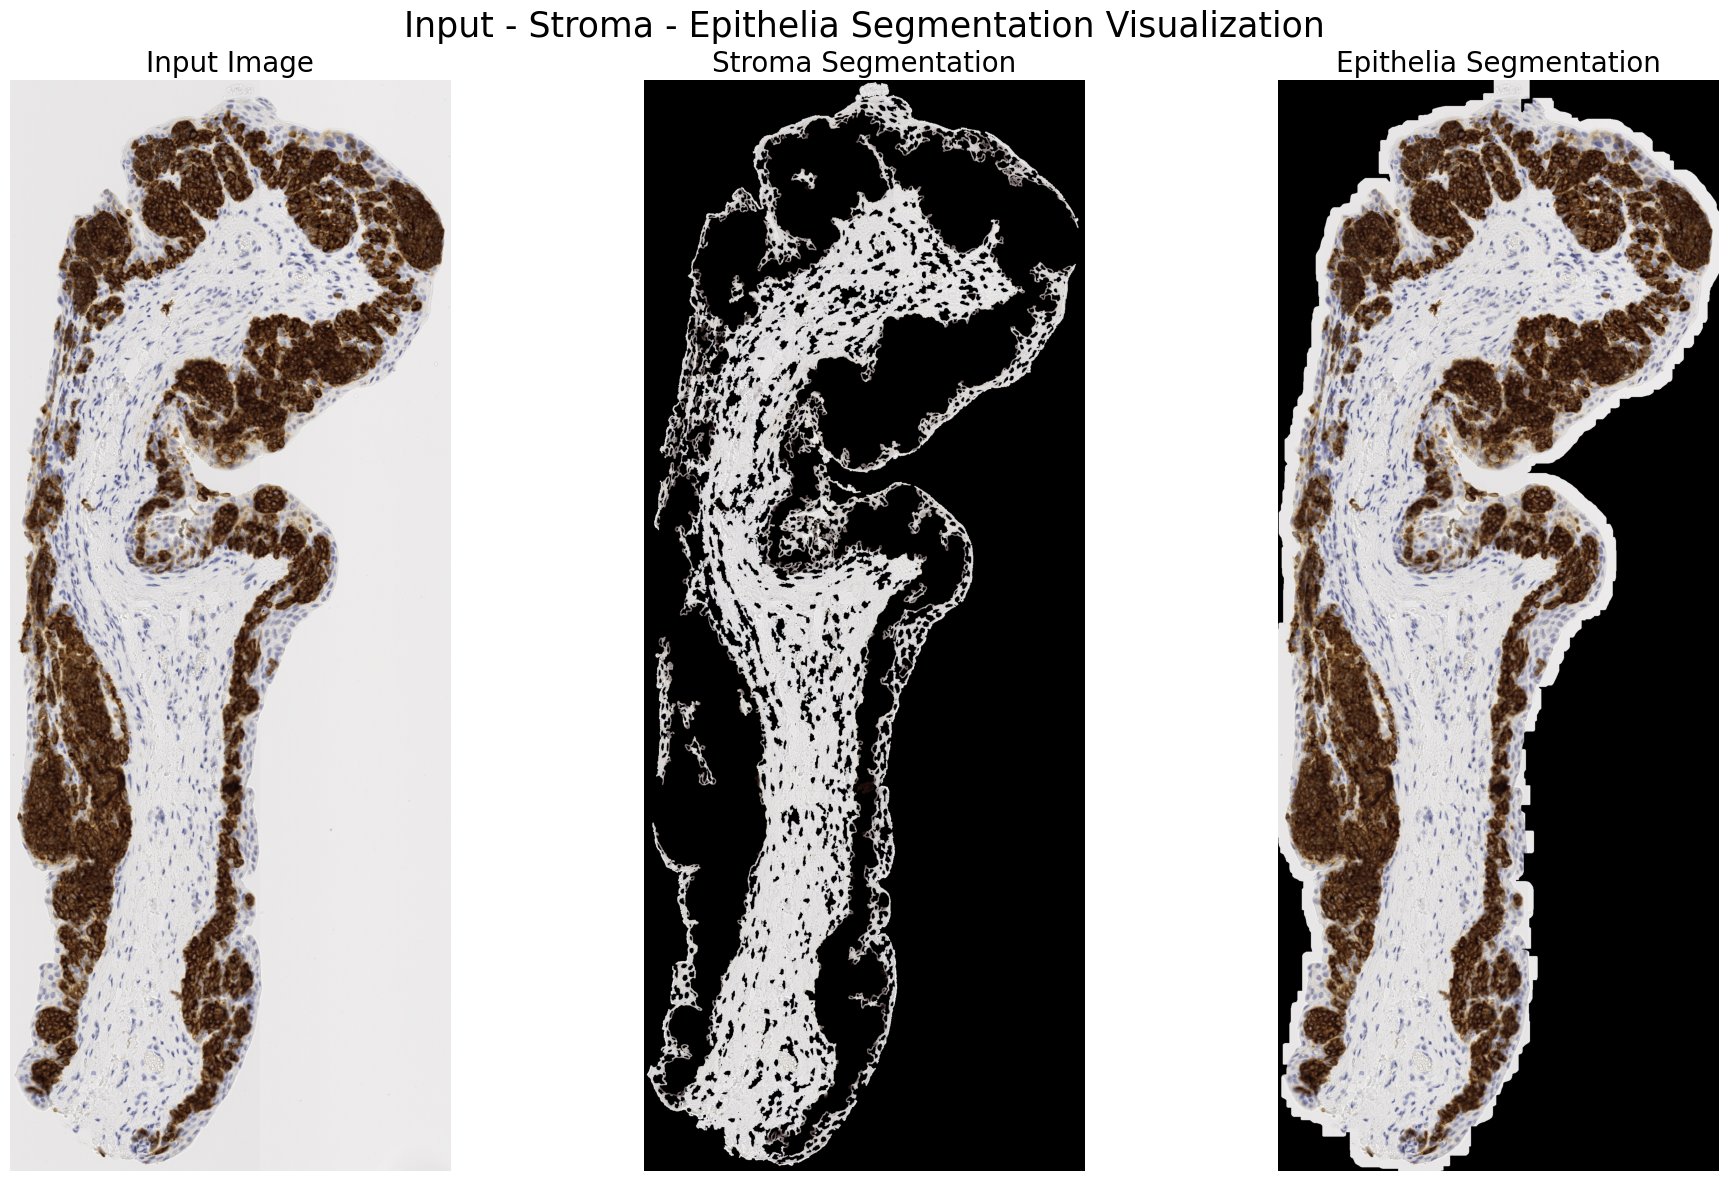

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import morphology
import gc
from scipy.ndimage import gaussian_filter

# Settings for single image processing
show_images = 0                                # to display images in real-time
save_intermediate_images = 0                   # save R-G-B and Y-Cb-Cr Channels
output_dir = "extracted"                       # epithelia and stroma will be saved here
image_name = 'h2114153  melan_ROI_2.tif'        # specific image to process
save_epithelia_and_stroma = 1                  # to save epithelia and stroma output

# Visualization settings
output_visualization_dir = "extracted/visualization"         # output for visual comparison
save_bins_representation = 1                                 # save Lumma and Red Chroma Bins for visualization

# Ensure necessary directories exist
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
    print(f"Output directory '{output_dir}' created.")

if not os.path.isdir(output_visualization_dir):
    os.mkdir(output_visualization_dir)
    print(f"Output visualization directory '{output_visualization_dir}' created.")

# Plot function for optional display
def imshow(img, title):
    if show_images == 0:
        return
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    plt.title(title)
    plt.show()

# Main processing function for a single image
def process_single_image(image_name):
    # Check if the input file exists
    input_filepath = image_name
    if not os.path.isfile(input_filepath):
        print(f"File '{input_filepath}' does not exist! Exiting...")
        return

    print(f"Processing image: {input_filepath}")

    # Load the image
    img_rgb = cv2.imread(input_filepath)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    imshow(img_rgb, 'Input Image')

    # Convert to YCrCb color space
    img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)

    # Define binning in lumma image
    lumma_bins_n = 20
    divisor = (np.floor(255 / lumma_bins_n)).astype(np.uint8)
    lumma_binned = (np.floor(img_ycrcb[:, :, 0] / divisor)).astype(np.uint8)

    # Find the most populated lumma bin
    most_pixels_bin = np.argmax(np.bincount(lumma_binned.ravel()))
    background = lumma_binned == most_pixels_bin
    background = morphology.remove_small_objects(background, 5000)
    background = morphology.remove_small_holes(background, 10000)

    # Red Chroma segmentation for stroma and epithelia
    Cr_bins_n = 100
    divisor = (np.floor(255 / Cr_bins_n)).astype(np.uint8)
    Cr_binned = (np.floor(img_ycrcb[:, :, 2] / divisor)).astype(np.uint8)

    # Find stroma
    most_pixels_bin = np.argmax(np.bincount(Cr_binned.ravel()))
    stroma_bin = most_pixels_bin
    stroma = np.isin(Cr_binned, [stroma_bin, stroma_bin - 1, stroma_bin - 2])
    stroma = stroma * np.invert(background)
    stroma = morphology.dilation(stroma, morphology.square(3))
    stroma = morphology.remove_small_objects(stroma, 1000)

    # Find epithelia
    epithelia_bin = stroma_bin - 2
    epithelia = np.isin(Cr_binned, [epithelia_bin, epithelia_bin - 1, epithelia_bin - 2])
    epithelia = epithelia * np.invert(background)
    epithelia = morphology.dilation(epithelia, morphology.square(3))
    epithelia = gaussian_filter(epithelia.astype(float), sigma=4)
    epithelia = epithelia > 0.25  # Convert back to binary by thresholding
    epithelia = morphology.remove_small_holes(epithelia, 2500)
    epithelia = morphology.dilation(epithelia, morphology.square(50))
    epithelia = morphology.remove_small_objects(epithelia, 15000)
    epithelia = morphology.remove_small_holes(epithelia, 20000)

    # Save segmentation results
    if save_epithelia_and_stroma:
        epithelia_img = cv2.bitwise_and(img_rgb, img_rgb, mask=(epithelia.astype(np.uint8) * 255))
        stroma_img = cv2.bitwise_and(img_rgb, img_rgb, mask=(stroma.astype(np.uint8) * 255))
        filename = os.path.join(output_dir, image_name + " Epithelia.png")
        cv2.imwrite(filename, cv2.cvtColor(epithelia_img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_PNG_COMPRESSION, 0])
        print(f"{filename} saved")
        filename = os.path.join(output_dir, image_name + " Stroma.png")
        cv2.imwrite(filename, cv2.cvtColor(stroma_img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_PNG_COMPRESSION, 0])
        print(f"{filename} saved")

    # Visualization of final segmentation
    fig = plt.figure(num=1, clear=True, figsize=(20, 12))
    ax_arr = fig.subplots(1, 3, sharex=True, sharey=True)
    fig.suptitle('Input - Stroma - Epithelia Segmentation Visualization', fontsize=25)
    ax1, ax2, ax3 = ax_arr.ravel()
    ax1.imshow(img_rgb)
    ax1.set_title('Input Image', fontsize=20)
    ax1.set_axis_off()
    ax2.imshow(stroma_img)
    ax2.set_title('Stroma Segmentation', fontsize=20)
    ax2.set_axis_off()
    ax3.imshow(epithelia_img)
    ax3.set_title('Epithelia Segmentation', fontsize=20)
    ax3.set_axis_off()
    plt.tight_layout()
    filename = os.path.join(output_visualization_dir, image_name + ".png")
    plt.savefig(filename)
    print(f"{filename} saved")
    if show_images:
        plt.show()

    print("Segmentation complete for single image.")

    # Clean up memory
    del img_rgb, img_ycrcb, stroma_img, epithelia_img, background, epithelia, stroma, Cr_binned, lumma_binned
    gc.collect()

# Call the function to process the single image
process_single_image(image_name)


# Kevin: sox10

adjusted for only one image

takes in already matched extracted sox10 slice. no preprocessing

Processing image: h2114153 sox10_ROI_1.tif
extracted/h2114153 sox10_ROI_1.tif Epithelia.png saved
extracted/h2114153 sox10_ROI_1.tif Stroma.png saved
extracted/visualization/h2114153 sox10_ROI_1.tif.png saved
Segmentation complete for single image.


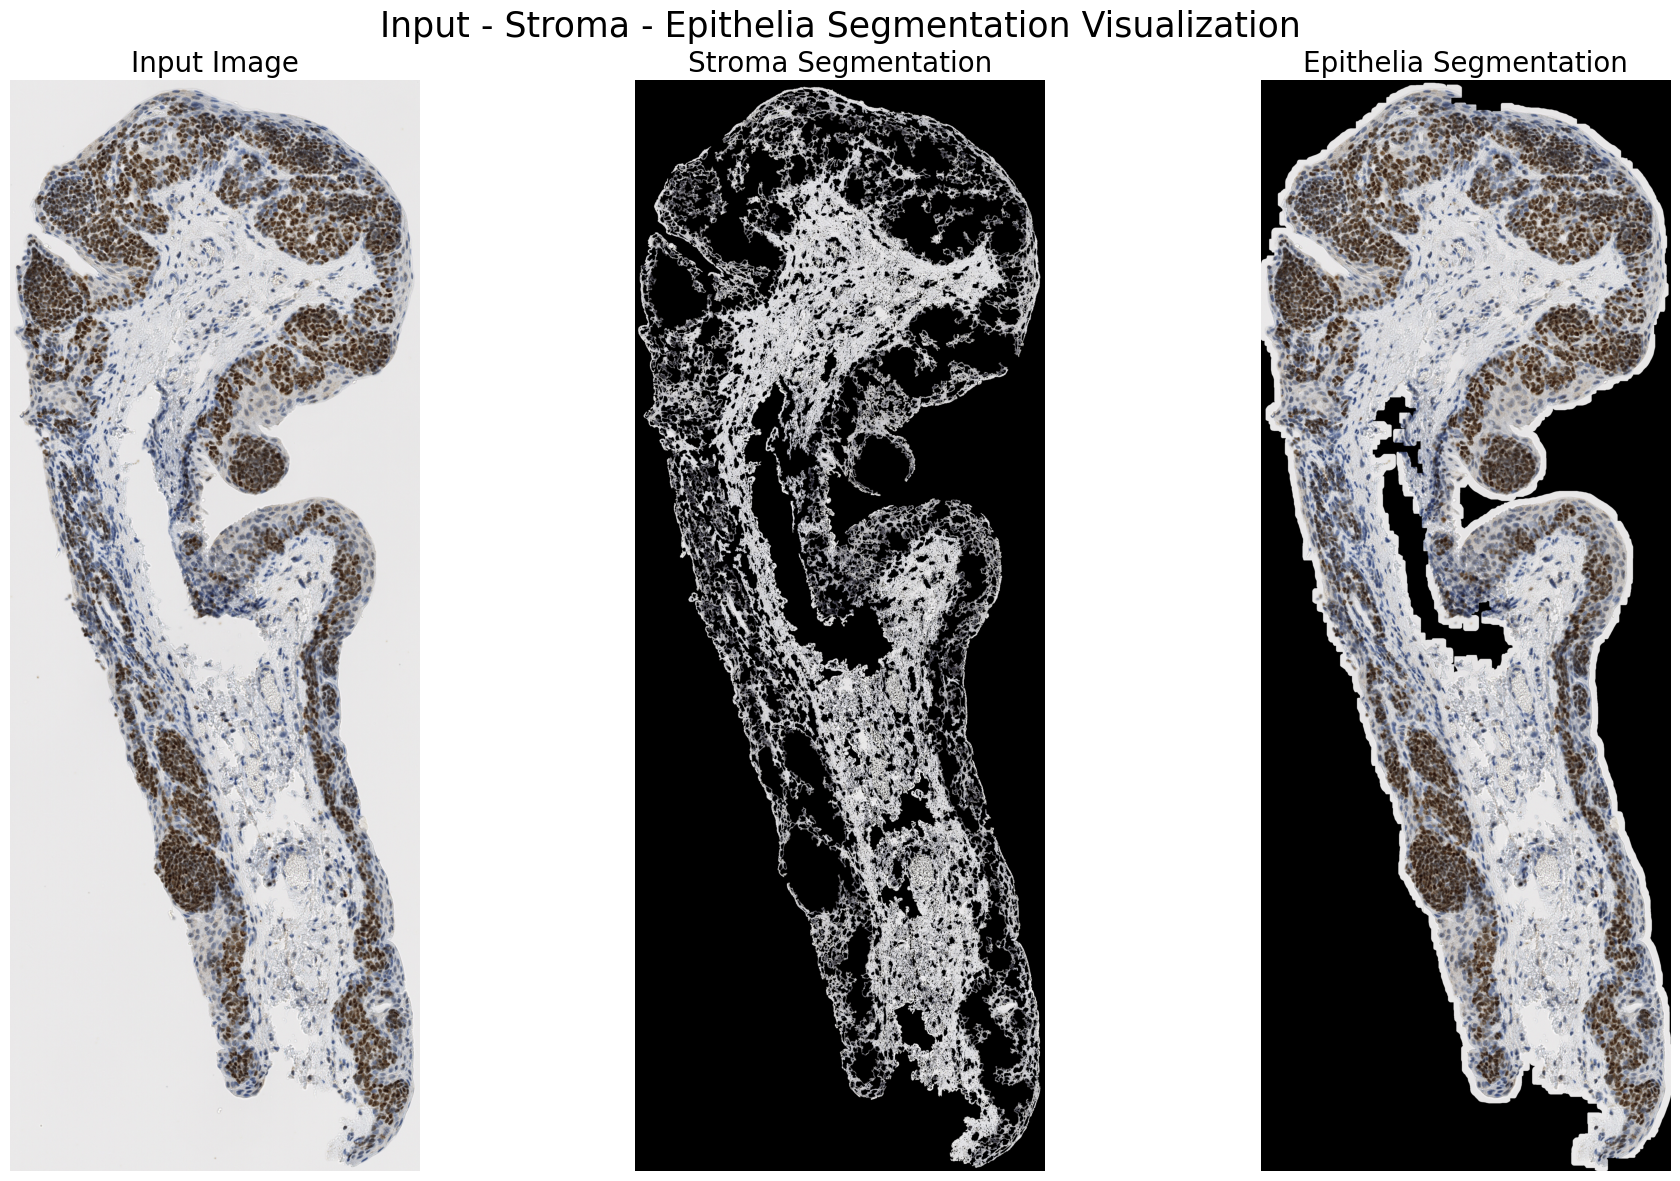

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import morphology
import gc
from scipy.ndimage import gaussian_filter

# Settings for single image processing
show_images = 0                                # to display images in real-time
save_intermediate_images = 0                   # save R-G-B and Y-Cb-Cr Channels
output_dir = "extracted"                       # epithelia and stroma will be saved here
image_name = 'h2114153 sox10_ROI_1.tif'        # specific image to process
save_epithelia_and_stroma = 1                  # to save epithelia and stroma output

# Visualization settings
output_visualization_dir = "extracted/visualization"         # output for visual comparison
save_bins_representation = 1                                 # save Lumma and Red Chroma Bins for visualization

# Ensure necessary directories exist
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
    print(f"Output directory '{output_dir}' created.")

if not os.path.isdir(output_visualization_dir):
    os.mkdir(output_visualization_dir)
    print(f"Output visualization directory '{output_visualization_dir}' created.")

# Plot function for optional display
def imshow(img, title):
    if show_images == 0:
        return
    plt.imshow(img)
    plt.tight_layout()
    plt.axis('off')
    plt.title(title)
    plt.show()

# Main processing function for a single image
def process_single_image(image_name):
    # Check if the input file exists
    input_filepath = image_name
    if not os.path.isfile(input_filepath):
        print(f"File '{input_filepath}' does not exist! Exiting...")
        return

    print(f"Processing image: {input_filepath}")

    # Load the image
    img_rgb = cv2.imread(input_filepath)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    imshow(img_rgb, 'Input Image')

    # Convert to YCrCb color space
    img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YCrCb)

    # Define binning in lumma image
    lumma_bins_n = 20
    divisor = (np.floor(255 / lumma_bins_n)).astype(np.uint8)
    lumma_binned = (np.floor(img_ycrcb[:, :, 0] / divisor)).astype(np.uint8)

    # Find the most populated lumma bin
    most_pixels_bin = np.argmax(np.bincount(lumma_binned.ravel()))
    background = lumma_binned == most_pixels_bin
    background = morphology.remove_small_objects(background, 5000)
    background = morphology.remove_small_holes(background, 10000)

    # Red Chroma segmentation for stroma and epithelia
    Cr_bins_n = 200
    divisor = (np.floor(255 / Cr_bins_n)).astype(np.uint8)
    Cr_binned = (np.floor(img_ycrcb[:, :, 1] / divisor)).astype(np.uint8)

    # Find stroma
    most_pixels_bin = np.argmax(np.bincount(Cr_binned.ravel()))
    stroma_bin = most_pixels_bin
    stroma = np.isin(Cr_binned, [stroma_bin, stroma_bin - 1, stroma_bin - 2])
    stroma = stroma * np.invert(background)
    stroma = morphology.dilation(stroma, morphology.square(3))
    stroma = morphology.remove_small_objects(stroma, 1000)

    # Find epithelia
    epithelia_bin = stroma_bin + 1
    epithelia = np.isin(Cr_binned, [epithelia_bin, epithelia_bin + 1, epithelia_bin + 2, epithelia_bin + 3])
    epithelia = epithelia * np.invert(background)
    epithelia = morphology.dilation(epithelia, morphology.square(3))
    epithelia = gaussian_filter(epithelia.astype(float), sigma=6)
    epithelia = epithelia > 0.2  # Convert back to binary by thresholding
    epithelia = morphology.remove_small_holes(epithelia, 2500)
    epithelia = morphology.remove_small_objects(epithelia, 250)
    epithelia = morphology.dilation(epithelia, morphology.square(50))
    epithelia = morphology.remove_small_objects(epithelia, 15000)
    epithelia = morphology.remove_small_holes(epithelia, 20000)

    # Save segmentation results
    if save_epithelia_and_stroma:
        epithelia_img = cv2.bitwise_and(img_rgb, img_rgb, mask=(epithelia.astype(np.uint8) * 255))
        stroma_img = cv2.bitwise_and(img_rgb, img_rgb, mask=(stroma.astype(np.uint8) * 255))
        filename = os.path.join(output_dir, image_name + " Epithelia.png")
        cv2.imwrite(filename, cv2.cvtColor(epithelia_img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_PNG_COMPRESSION, 0])
        print(f"{filename} saved")
        filename = os.path.join(output_dir, image_name + " Stroma.png")
        cv2.imwrite(filename, cv2.cvtColor(stroma_img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_PNG_COMPRESSION, 0])
        print(f"{filename} saved")

    # Visualization of final segmentation
    fig = plt.figure(num=1, clear=True, figsize=(20, 12))
    ax_arr = fig.subplots(1, 3, sharex=True, sharey=True)
    fig.suptitle('Input - Stroma - Epithelia Segmentation Visualization', fontsize=25)
    ax1, ax2, ax3 = ax_arr.ravel()
    ax1.imshow(img_rgb)
    ax1.set_title('Input Image', fontsize=20)
    ax1.set_axis_off()
    ax2.imshow(stroma_img)
    ax2.set_title('Stroma Segmentation', fontsize=20)
    ax2.set_axis_off()
    ax3.imshow(epithelia_img)
    ax3.set_title('Epithelia Segmentation', fontsize=20)
    ax3.set_axis_off()
    plt.tight_layout()
    filename = os.path.join(output_visualization_dir, image_name + ".png")
    plt.savefig(filename)
    print(f"{filename} saved")
    if show_images:
        plt.show()

    print("Segmentation complete for single image.")

    # Clean up memory
    del img_rgb, img_ycrcb, stroma_img, epithelia_img, background, epithelia, stroma, Cr_binned, lumma_binned
    gc.collect()

# Call the function to process the single image
process_single_image(image_name)


# Cross-View using Epithelium Anchor Points

With h&e epithelium from prashant and sox10/melana from kevin.

Not really successful

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms as transforms
from PIL import Image, ImageDraw

# Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        backbone = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])  # Remove fully connected layers

    def forward(self, x):
        return self.feature_extractor(x)  # Output feature map

# Cross-View Transformer
class CrossViewTransformer(nn.Module):
    def __init__(self, feature_dim, num_heads, num_layers):
        super(CrossViewTransformer, self).__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=feature_dim, nhead=num_heads, dim_feedforward=1024, activation='relu')
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(feature_dim)

    def forward(self, query, key, value):
        for layer in self.layers:
            query = layer(query + key + value)
        return self.norm(query)

# Load Epithelium Mask and Calculate Full-Resolution Bounding Box
def calculate_full_resolution_epithelium_box(mask_path):
    mask_image = Image.open(mask_path).convert("L")  # Convert to grayscale
    np_mask = np.array(mask_image)
    binary_mask = np_mask > 0  # True where epithelium exists
    coords = np.argwhere(binary_mask)
    if coords.size == 0:
        raise ValueError("No epithelium detected in the mask.")
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return y_min, y_max, x_min, x_max

# Extract Full Color Patch within Epithelium Bounding Box
def extract_color_patch(original_image, epithelium_box, patch_size=(256, 256)):
    y_min, y_max, x_min, x_max = epithelium_box
    y_center = (y_min + y_max) // 2
    x_center = (x_min + x_max) // 2

    x_start = max(0, x_center - patch_size[0] // 2)
    y_start = max(0, y_center - patch_size[1] // 2)
    x_end = min(original_image.width, x_start + patch_size[0])
    y_end = min(original_image.height, y_start + patch_size[1])

    patch = original_image.crop((x_start, y_start, x_end, y_end))
    return patch, (x_start, y_start, x_end, y_end)

# Draw Bounding Box on the Original Image
def draw_bounding_box(image, box_coords, color="blue", thickness=3):
    draw = ImageDraw.Draw(image)
    x_start, y_start, x_end, y_end = box_coords
    for i in range(thickness):
        draw.rectangle([x_start - i, y_start - i, x_end + i, y_end + i], outline=color)

# Save Patch as Image
def save_patch_as_image(patch, output_folder, stain_name):
    os.makedirs(output_folder, exist_ok=True)
    patch.save(os.path.join(output_folder, f"{stain_name}_aligned_patch.png"))

# Preprocess Image for Feature Extraction
def preprocess_image(image_path, input_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0), image

# Main Pipeline with Saving Option
def process_images_with_epithelium(image_paths, mask_paths, patch_size=(256, 256), output_folder="epithelium_patches"):
    h_e_tensor, h_e_image = preprocess_image(image_paths[0])
    melana_tensor, melana_image = preprocess_image(image_paths[1])
    sox10_tensor, sox10_image = preprocess_image(image_paths[2])

    feature_extractor = FeatureExtractor()
    feature_dim = 2048  # Feature map channels from ResNet50
    cross_view_transformer = CrossViewTransformer(feature_dim=feature_dim, num_heads=8, num_layers=4)

    h_e_features = feature_extractor(h_e_tensor)
    melana_features = feature_extractor(melana_tensor)
    sox10_features = feature_extractor(sox10_tensor)

    # Calculate bounding boxes for each stain
    h_e_box = calculate_full_resolution_epithelium_box(mask_paths[0])
    melana_box = calculate_full_resolution_epithelium_box(mask_paths[1])
    sox10_box = calculate_full_resolution_epithelium_box(mask_paths[2])

    print(f"H&E Bounding Box: {h_e_box}")
    print(f"Melan-A Bounding Box: {melana_box}")
    print(f"Sox10 Bounding Box: {sox10_box}")

    # Align features using the cross-view transformer
    b, c, h, w = h_e_features.shape
    h_e_features_flat = h_e_features.flatten(2).permute(0, 2, 1)
    melana_features_flat = melana_features.flatten(2).permute(0, 2, 1)
    sox10_features_flat = sox10_features.flatten(2).permute(0, 2, 1)

    aligned_h_e_flat = cross_view_transformer(h_e_features_flat, melana_features_flat, sox10_features_flat)
    aligned_melana_flat = cross_view_transformer(melana_features_flat, h_e_features_flat, sox10_features_flat)
    aligned_sox10_flat = cross_view_transformer(sox10_features_flat, h_e_features_flat, melana_features_flat)

    aligned_h_e = aligned_h_e_flat.permute(0, 2, 1).reshape(b, c, h, w)
    aligned_melana = aligned_melana_flat.permute(0, 2, 1).reshape(b, c, h, w)
    aligned_sox10 = aligned_sox10_flat.permute(0, 2, 1).reshape(b, c, h, w)

    # Extract patches from aligned feature maps
    h_e_patch, h_e_box_coords = extract_color_patch(h_e_image, h_e_box, patch_size)
    melana_patch, melana_box_coords = extract_color_patch(melana_image, melana_box, patch_size)
    sox10_patch, sox10_box_coords = extract_color_patch(sox10_image, sox10_box, patch_size)

    draw_bounding_box(h_e_image, h_e_box_coords, color="red")
    draw_bounding_box(melana_image, melana_box_coords, color="red")
    draw_bounding_box(sox10_image, sox10_box_coords, color="red")

    annotated_output_folder = os.path.join(output_folder, "annotated")
    os.makedirs(annotated_output_folder, exist_ok=True)
    h_e_image.save(os.path.join(annotated_output_folder, "H&E_with_bbox.png"))
    melana_image.save(os.path.join(annotated_output_folder, "Melana_with_bbox.png"))
    sox10_image.save(os.path.join(annotated_output_folder, "Sox10_with_bbox.png"))

    save_patch_as_image(h_e_patch, output_folder, "H&E")
    save_patch_as_image(melana_patch, output_folder, "Melana")
    save_patch_as_image(sox10_patch, output_folder, "Sox10")

    return h_e_patch, melana_patch, sox10_patch

# Run the Pipeline
if __name__ == "__main__":
    image_paths = [
        'h2114153  h&e_ROI_5.tif',
        'h2114153  melan_ROI_2.tif',
        'h2114153 sox10_ROI_1.tif',
    ]
    mask_paths = [
        'extracted/h2114153  h&e_ROI_5.tif Epithelia.png',
        'extracted/h2114153  melan_ROI_2.tif Epithelia.png',
        'extracted/h2114153 sox10_ROI_1.tif Epithelia.png',
    ]

    h_e_patch, melana_patch, sox10_patch = process_images_with_epithelium(image_paths, mask_paths)
    print("Aligned patches saved successfully.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


H&E Bounding Box: (32, 5737, 55, 2389)
Melan-A Bounding Box: (0, 2983, 0, 1203)
Sox10 Bounding Box: (15, 5887, 0, 2211)
Aligned patches saved successfully.
